In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
import sys
sys.path.insert(0, "../")

import pandas as pd
import scipy
from scipy import stats as stats
import numpy as np
from functools import partial
import copy
import seaborn as sns

# from generic.latexify import *

from utilities import *
from payment.payment_functions import *
from payment.payment_function_evaluation import *
from payment.payment_function_templates import *

In [13]:
folder = '../data/rideaustin/'
filename = 'rides_validreverseengineered.csv'

In [14]:
df = load_data(folder, filename)

C:\Users\Nikhil\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [15]:
print(df.columns)

Index(['started_on', 'created_date', 'updated_date', 'completed_on',
       'distance_travelled', 'end_location_lat', 'end_location_long',
       'driver_rating', 'rider_rating', 'active_driver_id', 'charity_id',
       'requested_car_category', 'free_credit_used', 'surge_factor',
       'start_location_long', 'start_location_lat', 'rider_id',
       'round_up_amount', 'promocode_redemption_id', 'driver_reached_on',
       'base_fare', 'total_fare', 'rate_per_mile', 'rate_per_minute',
       'time_fare', 'driver_accepted_on', 'esimtated_time_arrive', 'tipped_on',
       'tip', 'driving_time_to_rider', 'dispatch_location_lat',
       'dispatch_location_long', 'driving_distance_to_rider', 'dispatched_on',
       'status', 'driver_id', 'car_id', 'color', 'make', 'model', 'year',
       'car_categories_bitmask', 'rating', 'cancelled_on',
       'started_on_hours_since_epoch', 'completed_on_hours_since_epoch',
       'dispatched_on_hours_since_epoch', 'start_hour', 'start_hour_rounded',
   

In [16]:
df_10hours = load_data(folder, 'rides_10hours.csv')
df_oneday = load_data(folder, 'rides_24hours.csv')
# df_3weeks = load_data(folder, 'rides_3weeks.csv')

In [9]:
df_small = df.sample(1000)
dfs = [df, df_10hours, df_oneday, df_small]
df_names = ['', '_10hrs', '_24hrs', '_small']

In [17]:
for en in range(len(dfs)):
    dfs[en] = payment_reverse_engineer(dfs[en])

## Do the same thing I did in other notebook for pure add/mult surge, but for the add surge with the min fare, etc

In [45]:
def find_parameters_for_dataset(dfloc, dfname):
    unique_surge_factors = dfloc.surge_factor.unique()
    
    additive_by_surge = {}

    for surge_factor in unique_surge_factors:
        print(surge_factor)
        dflocsurge = dfloc.query('surge_factor == @surge_factor')

        func_addwithmin = partial(withmin_additive_surge_withparams, col_name = 'withmin_addsurge_fare')
   
        additive_by_surge[surge_factor] = binary_search_to_find_parameter(dflocsurge, func_addwithmin, 'mimic_fare', 'withmin_addsurge_fare', print_stuff = False)  
    
    print('additives_by_surge_withmin{} = {}'.format(dfname,additive_by_surge))
    
    #test that they work, by plotting mean surge payments by surge factor
    func_addwithmin_bysurge = partial(withmin_additive_bysurgefactor_withparams, additives_by_surge = additive_by_surge, col_name = 'withmin_addsurge_bysurgefactor_fare')
    dfloc = func_addwithmin_bysurge(dfloc)

    plot_meanpayment_bysurgefactor(dfloc, ['withmin_addsurge_bysurgefactor_fare', 'mimic_fare'])
    plt.show()
    return additive_by_surge

1.0


C:\Users\Nikhil\Miniconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Nikhil\Miniconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1.25
1.5
2.0
1.75
2.25
2.5
3.0
2.75
3.25
3.5
4.0
3.75
4.25
4.5
5.0
additives_by_surge_withmin = {1.0: 50.0, 1.25: 9.451798722147942, 1.5: 9.588177595287561, 2.0: 9.615769982337952, 1.75: 9.594031795859337, 2.25: 9.957537800073624, 2.5: 9.92576852440834, 3.0: 10.548560321331024, 2.75: 10.640523582696915, 3.25: 10.865232348442078, 3.5: 11.063981056213379, 4.0: 12.741836160421371, 3.75: 12.023009359836578, 4.25: 11.503374576568604, 4.5: 14.593738317489624, 5.0: 11.09071969985962}


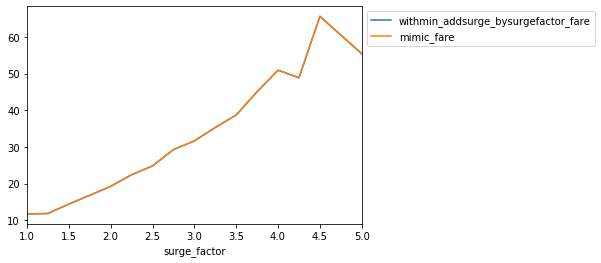

In [50]:
which = 0
additive_by_surge = find_parameters_for_dataset(dfs[which], df_names[which])

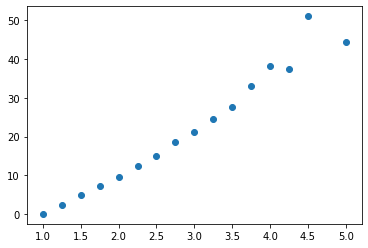

In [51]:
plt.scatter([x for x in additive_by_surge], [additive_by_surge[x]*(x-1) for x in additive_by_surge])

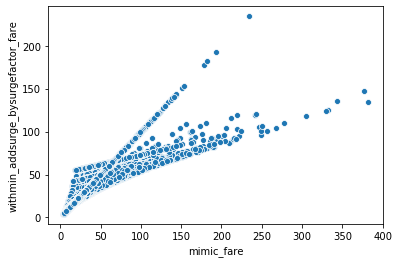

In [55]:
dfs[0] = withmin_additive_bysurgefactor(dfs[0])
sns.scatterplot(data= dfs[0], x = 'mimic_fare', y = 'withmin_addsurge_bysurgefactor_fare')